In [1]:
%matplotlib inline

from scipy.odr import *
from scipy.stats import *
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import ast
from multiprocessing import Pool, cpu_count

import ipywidgets as widgets

import scipy

from IPython import display
from matplotlib.patches import Rectangle

from sklearn.metrics import mean_squared_error
import json

import scipy.stats as st
from sklearn.metrics import r2_score


from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

import copy

from sklearn.model_selection import LeaveOneOut, LeavePOut

from multiprocessing import Pool
import cv2

In [2]:
df_filtered = pd.read_pickle("PklData/dfFiltered_LSTM.pkl")

In [3]:
df_filtered.head()

,userID,Timestamp,Current_Task,Task_amount,TaskID,VersionID,RepetitionID,Actual_Data,Is_Pause,Image
8093,17,1547138934425,1,680,6,2,1,True,False,"[0, 0, 192, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0..."
8094,17,1547138934455,1,680,6,2,1,True,False,"[0, 0, 192, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0..."
8095,17,1547138934493,1,680,6,2,1,True,False,"[0, 0, 192, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0..."
8096,17,1547138934533,1,680,6,2,1,True,False,"[0, 0, 192, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0..."
8097,17,1547138934573,1,680,6,2,1,True,False,"[0, 0, 192, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0..."


In [4]:
df_filtered.Image = df_filtered.Image.apply(lambda x: x.reshape(27, 15))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.clip(min=0, max=255))
df_filtered.Image = df_filtered.Image.apply(lambda x: x.astype(np.uint8))
df_filtered["ImageSum"] = df_filtered.Image.apply(lambda x: np.sum(x))

In [5]:
#LSTMs new Blob detection
def detect_blobs(image):
    #image = image.reshape(27, 15)
    large = np.ones((29,17), dtype=np.uint8)
    large[1:28,1:16] = image
    temp, thresh = cv2.threshold(cv2.bitwise_not(large), 200, 255, cv2.THRESH_BINARY)
    im2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [a for a in contours if cv2.contourArea(a) > 5 and cv2.contourArea(a) < 255]
    lstBlob  = []
    lstMin = []
    lstMax = []
    count = 0
    return len(contours) > 0

In [6]:
%%time
pool = Pool(cpu_count() - 2)
temp_blobs = pool.map(detect_blobs, df_filtered.Image)
pool.close()

CPU times: user 3.22 s, sys: 1.12 s, total: 4.34 s
Wall time: 4.67 s


In [7]:
df_filtered["ContainsBlobs"] = temp_blobs

In [8]:
#Label if knuckle or finger
def f(row):
    if row['TaskID'] < 17:
        #val = "Knuckle"
        val = 0
    elif row['TaskID'] >= 17:
        #val = "Finger"
        val = 1
    return val
df_filtered['InputMethod'] = df_filtered.apply(f, axis=1)

In [9]:
# Problem: some timestamps are strings (XXXXE+XXXX) which is not accurate enough, switching to index instead
"""def cast_to_int(x):
    if type(x) == int:
        return x
    x = str(x).replace(",", ".")
    return int(float(x))

df_filtered.Timestamp = df_filtered.Timestamp.map(cast_to_int)"""
df_filtered.index = range(len(df_filtered))

In [10]:
%%time
UserIDs = []
TaskIDs = []
VersionIDs = []
Blobs = []
for userID in df_filtered.userID.unique():
    print(userID)
    for TaskID in df_filtered[df_filtered.userID == userID].TaskID.unique():
        for VersionID in df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID)].VersionID.unique():
            first_blob = -1
            last_blob = -1
            for index, row in df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID) & (df_filtered.VersionID == VersionID)].iterrows():
                if row.ContainsBlobs:
                    last_blob = index
                    if first_blob == -1:
                        first_blob = index
            if first_blob >= 0 and last_blob >= 0:
                UserIDs.append(userID)
                TaskIDs.append(TaskID)
                VersionIDs.append(VersionID)
                Blobs.append(df_filtered[(df_filtered.userID == userID) & (df_filtered.TaskID == TaskID) & (df_filtered.VersionID == VersionID) & (df_filtered.index >= first_blob) & (df_filtered.index <= last_blob)].Image.values)

17
2
12
15
5
1
14
10
13
6
16
3
7
8
9
11
4
CPU times: user 2min 24s, sys: 134 ms, total: 2min 24s
Wall time: 2min 24s


In [21]:
UserIDs = np.array(UserIDs, dtype=np.int64)
TaskIDs = np.array(TaskIDs, dtype=np.int64)
VersionIDs = np.array(VersionIDs, dtype=np.int64)

In [22]:
df_lstm_all = pd.DataFrame()
df_lstm_all["userID"] = UserIDs
df_lstm_all["TaskID"] = TaskIDs
df_lstm_all["VersionID"] = VersionIDs
df_lstm_all["Blobs"] = Blobs
df_lstm_all.head()

,userID,TaskID,VersionID,Blobs
0,17,6,2,"[[[0, 0, 192, 0, 0, 0, 1, 176, 2, 2, 0, 0, 0, ..."
1,17,6,3,"[[[0, 0, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2, 1..."
2,17,6,4,"[[[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
3,17,6,5,"[[[0, 2, 2, 2, 2, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1..."
4,17,6,6,"[[[1, 1, 2, 2, 1, 1, 1, 0, 1, 4, 2, 2, 0, 0, 0..."


In [23]:
lengths = []
for index, row in df_lstm_all.iterrows():
    lengths.append(len(row.Blobs))
df_lstm_all["BlobCount"] = lengths

In [38]:
print("before: %s" % len(df_lstm_all))
df_lstm = df_lstm_all[(df_lstm_all.BlobCount <= 50) & (df_lstm_all.BlobCount >= 5)]
print("after: %s" % len(df_lstm))
print("ratio: %s" % ((len(df_lstm_all) - len(df_lstm)) / len(df_lstm_all) * 100))

before: 10755
after: 9745
ratio: 9.390980939098094


In [39]:
df_lstm.BlobCount.describe()

count    9745.000000
mean       17.469164
std         8.819778
min         5.000000
25%        11.000000
50%        16.000000
75%        21.000000
max        50.000000
Name: BlobCount, dtype: float64

In [26]:
df_lstm.to_pickle("PklData/df_lstm.pkl")

blob? True


<Figure size 432x288 with 0 Axes>

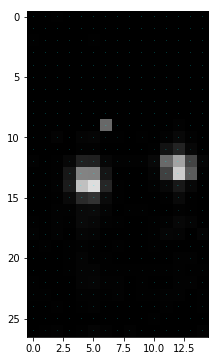

In [31]:
plt.clf()
plt.figure(figsize=(6, 6))
ax = plt.gca()

data = df_lstm_all[df_lstm_all.BlobCount >= 350].iloc[0].Blobs[0]
print("blob? %s" % detect_blobs(data))

plt.imshow(data, cmap='gray', vmin=0, vmax=255)
# Loop over data dimensions and create text annotations.
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        text = ax.text(j, i, int(data[i, j]),
                       ha="center", va="center", color="cyan", fontsize=1)
# plt.savefig("input.png", bbox_inches='tight')
plt.show()